# Introduction to Model Interpretability 

Author: Adebayo Oshingbesan


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1JgsK_Q7oqrp-QFHh82UPKew9qKwDV_jF?usp=sharing)

## Table of Contents
1. Introduction: Why Interpretability Matters
2. Foundations
3. Traditional ML Interpretability
4. Bonus Content- Chain of Thought Prompting

## Introduction: Why Interpretability Matters

**What it is:**  
Model interpretability is the ability for humans to understand how and why a machine learning model makes its decisions.

**Why we use it:**  
- **Trust:** Helps stakeholders gain confidence in models.
- **Debugging:** Pinpoints model failures.
- **Fairness:** Detects and mitigates bias.
- **Scientific Discovery:** Reveals hidden data patterns.
- **Regulation:** Meets requirements for explainable AI.

**Limitations:**  
- Interpretability is not absolute — different audiences require different explanations.
- Interpretability methods can be misleading if not validated.

### Setting Up Our Environment

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install shap lime
!pip install graphviz dtreeviz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, fetch_california_housing
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Part 1: Foundations


### What Makes a Model Interpretable?

Before diving into techniques, let's understand the key dimensions of interpretability:

1. **Transparency**: How well can we understand the model's mechanism?
2. **Simulatability**: Can a human mentally simulate the model's computation?
3. **Decomposability**: Can we understand individual components?

https://github.com/SeldonIO/alibi

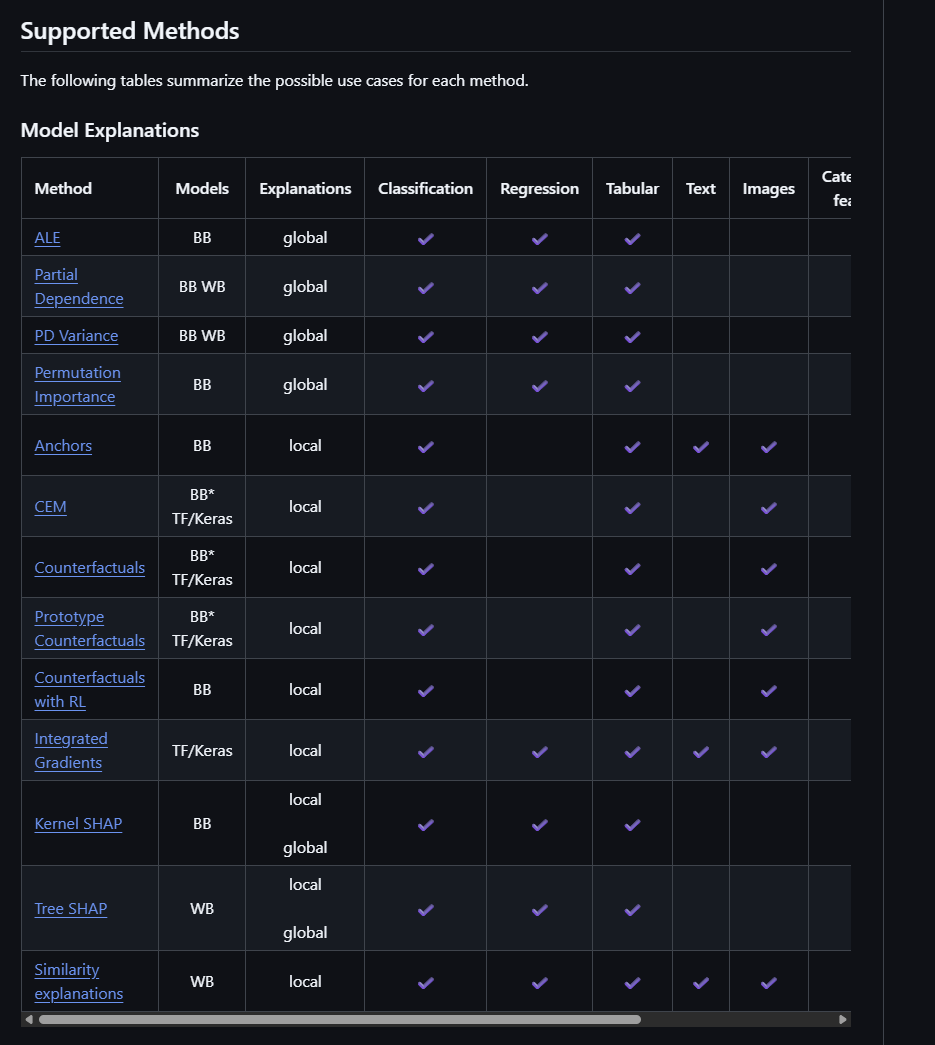

### Inherently Interpretable Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Generate sample data
X, y = make_classification(n_samples=1000, n_features=4, n_informative=3,
                          n_redundant=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

print("Linear Model Coefficients:")
for i, coef in enumerate(linear_model.coef_):
    print(f"Feature {i}: {coef:.4f}")
print(f"Intercept: {linear_model.intercept_:.4f}")

Linear Model Coefficients:
Feature 0: 0.2835
Feature 1: 0.1134
Feature 2: 0.0217
Feature 3: 0.0203
Intercept: 0.5337


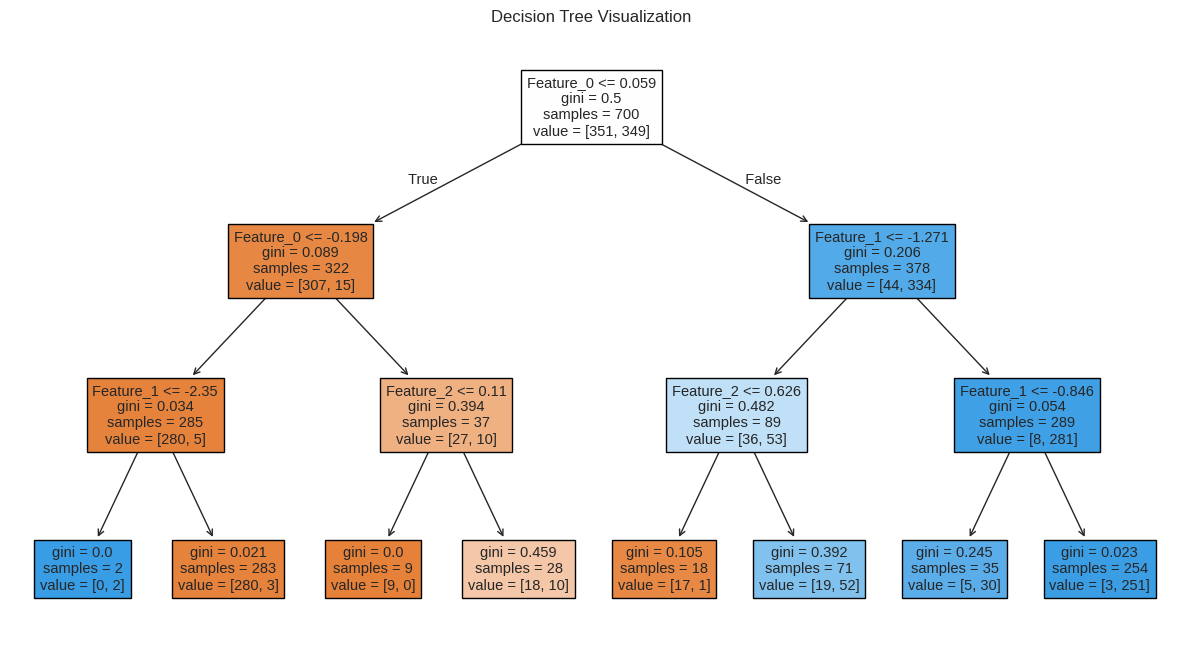

In [ ]:
# Example 2: Decision Tree (Interpretable with limitations)
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plot_tree(tree_model, filled=True, feature_names=[f'Feature_{i}' for i in range(4)])
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Let's explore the accuracy-interpretability trade-off
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

simple_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
deep_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
deep_random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

models = {
    'Decision Tree (depth=3)': simple_tree,
    'Decision Tree (depth=10)':deep_tree,
    'Random Forest (depth=3)': random_forest,
    'Deep Random Forest (depth=3)': deep_random_forest
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    results.append({'Model': name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
print(results_df)

                          Model  Accuracy
0       Decision Tree (depth=3)  0.906667
1      Decision Tree (depth=10)  0.916667
2       Random Forest (depth=3)  0.910000
3  Deep Random Forest (depth=3)  0.960000


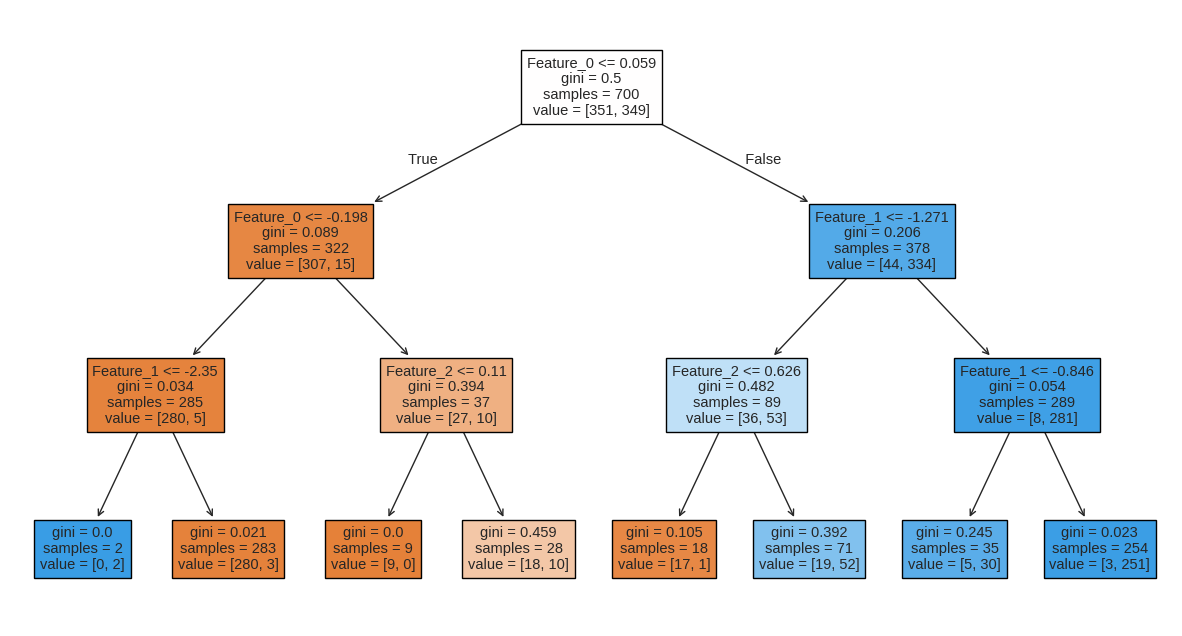

In [ ]:
plt.figure(figsize=(15, 8))
plot_tree(simple_tree, filled=True, feature_names=[f'Feature_{i}' for i in range(4)]);

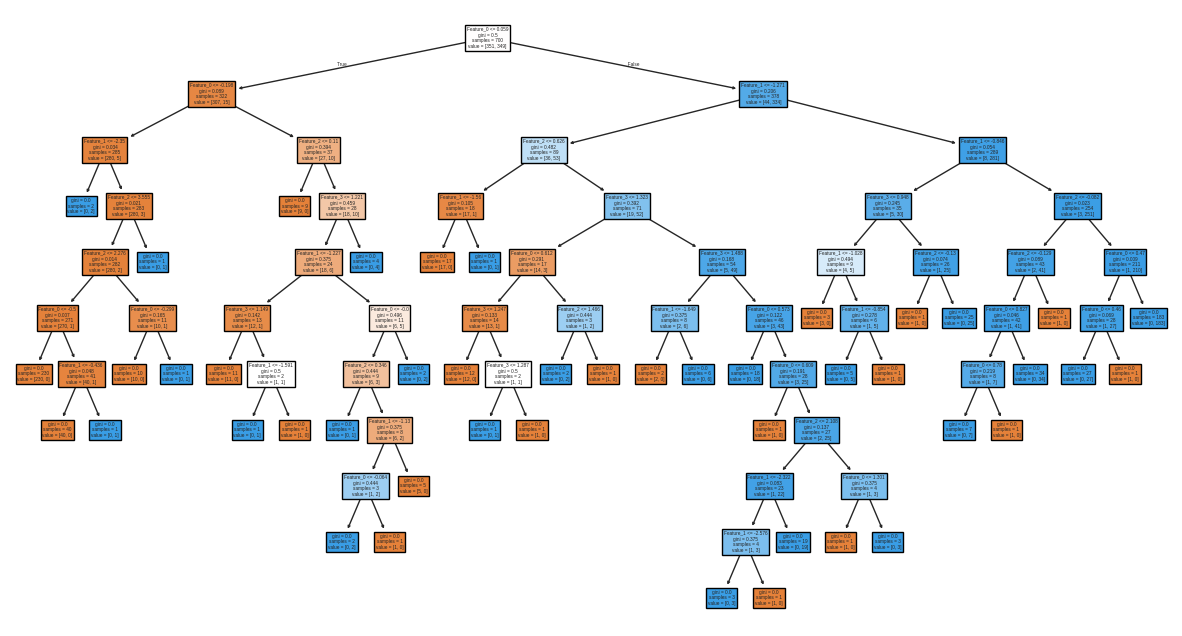

In [ ]:
plt.figure(figsize=(15, 8))
plot_tree(deep_tree, filled=True, feature_names=[f'Feature_{i}' for i in range(4)]);

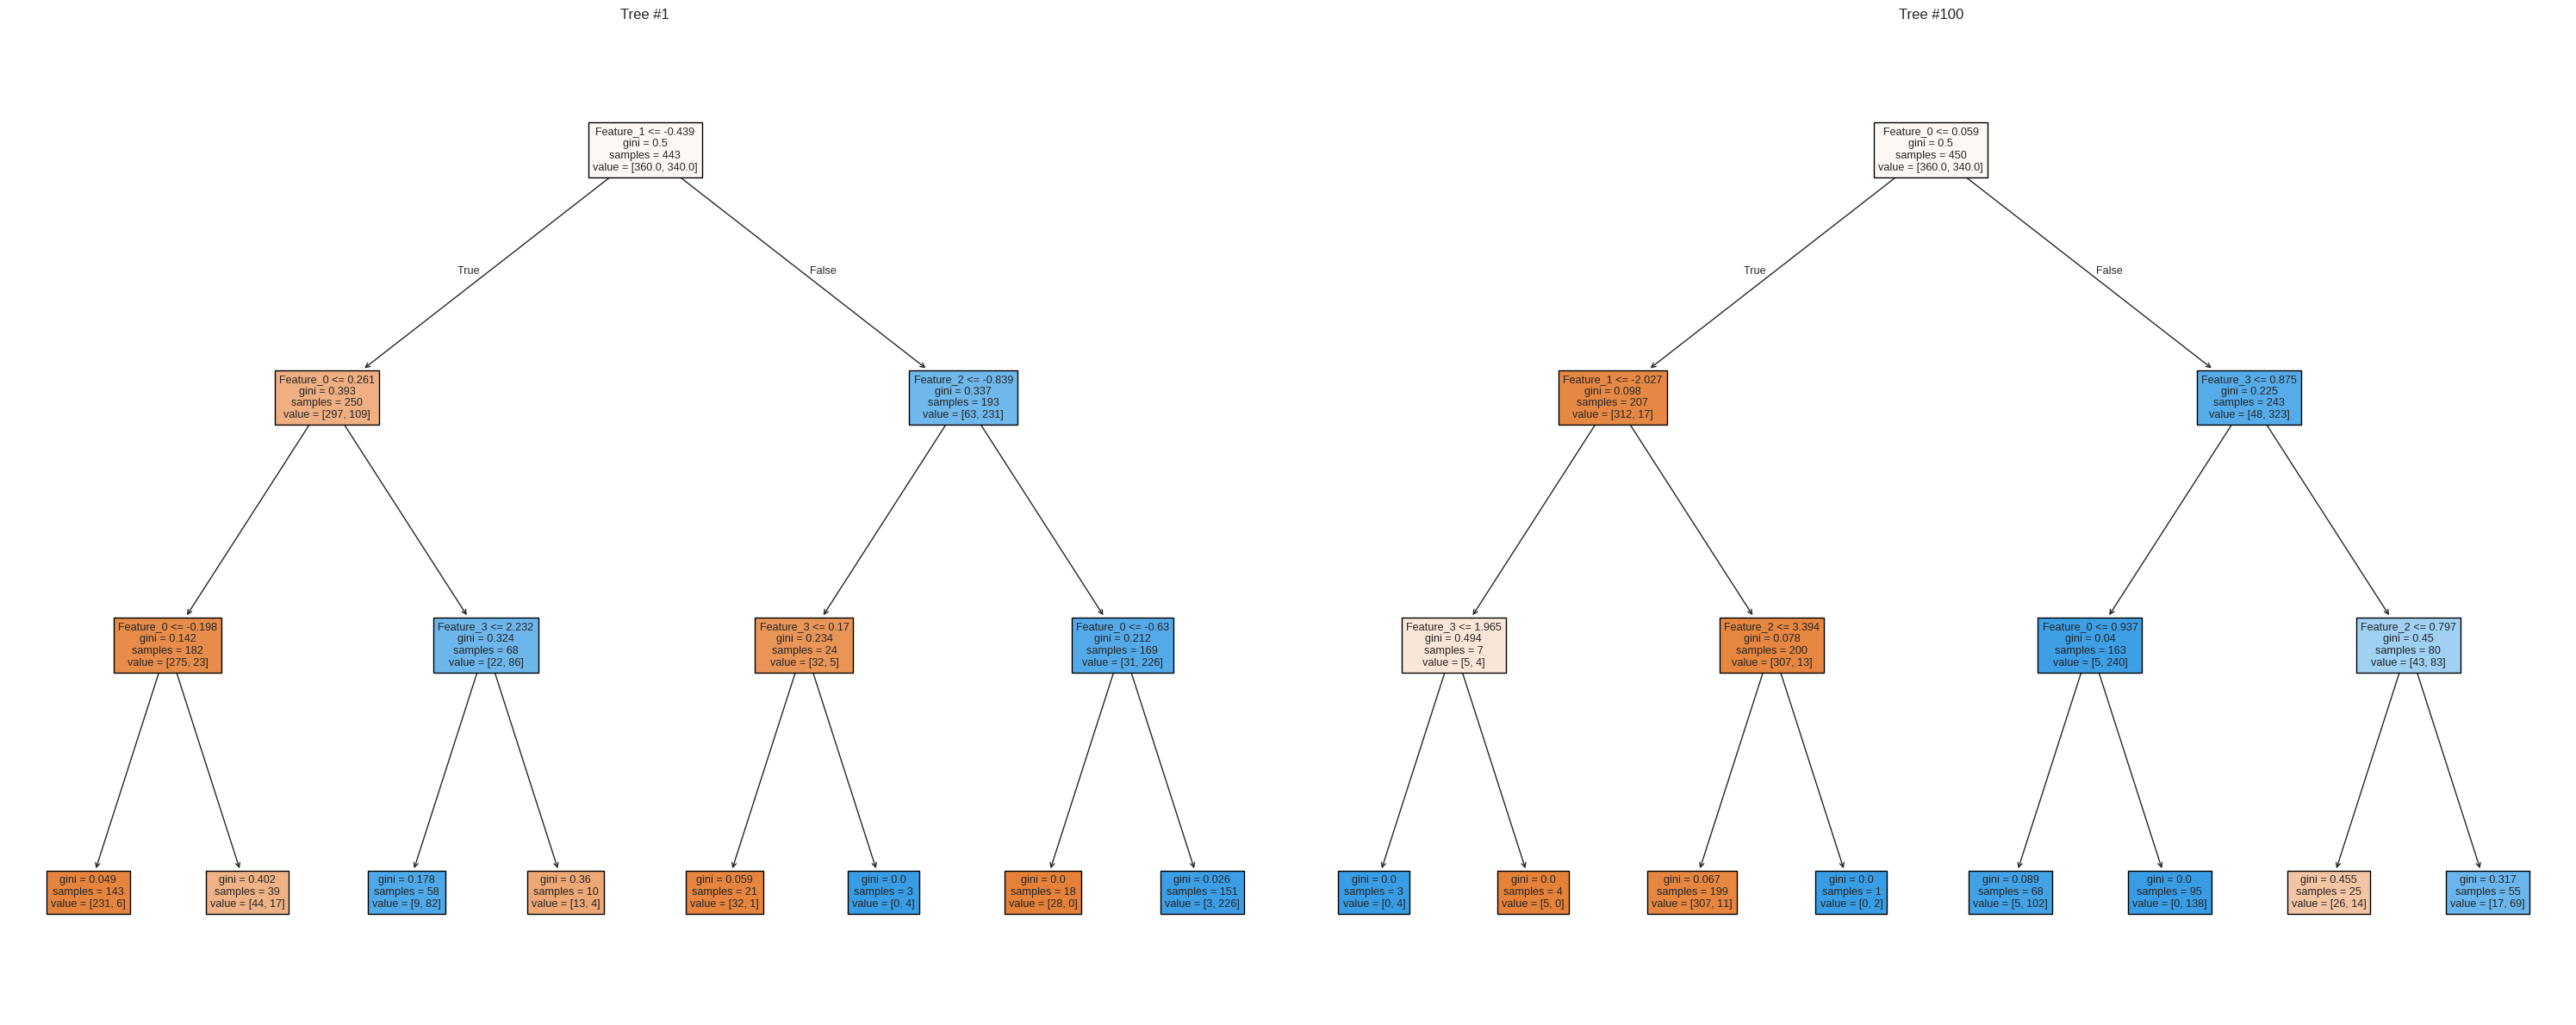

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

# Plot tree #50
plot_tree(
    random_forest.estimators_[0],
    filled=True,
    feature_names=[f'Feature_{i}' for i in range(4)],
    ax=axes[0]
)
axes[0].set_title("Tree #1")

# Plot tree #100
plot_tree(
    random_forest.estimators_[99],
    filled=True,
    feature_names=[f'Feature_{i}' for i in range(4)],
    ax=axes[1]
)
axes[1].set_title("Tree #100")

plt.tight_layout()
plt.show()

## Part 2: Traditional ML Interpretability

### Feature Importance

**What it is:**  
Measures contribution of features to predictions (via built-in or permutation methods).

**Why we use it:**  
Highlights global feature importance.

**Limitations:**  
- Built-in importance can be biased.
- Permutation is more reliable but expensive.

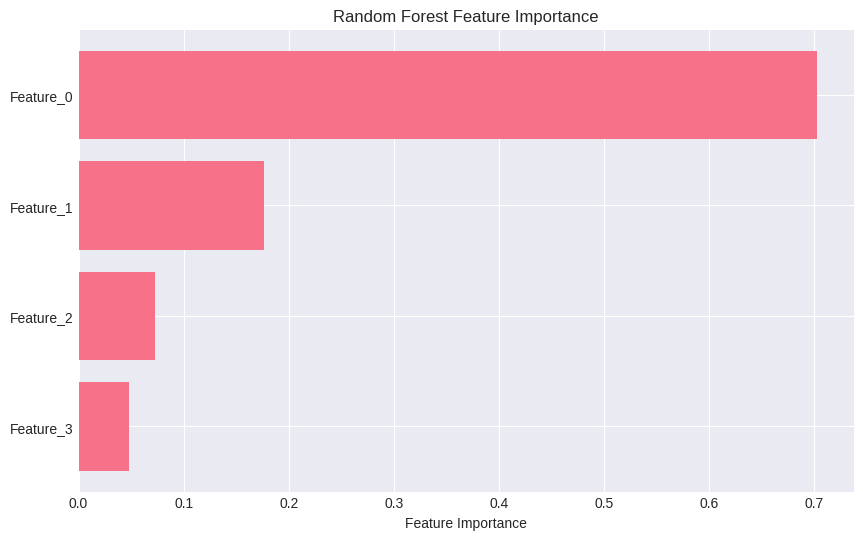

In [ ]:
# Method 1: Built-in Feature Importance (Gini/Entropy based)

feature_importance = pd.DataFrame({
    'feature': [f'Feature_{i}' for i in range(4)],
    'importance': random_forest.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


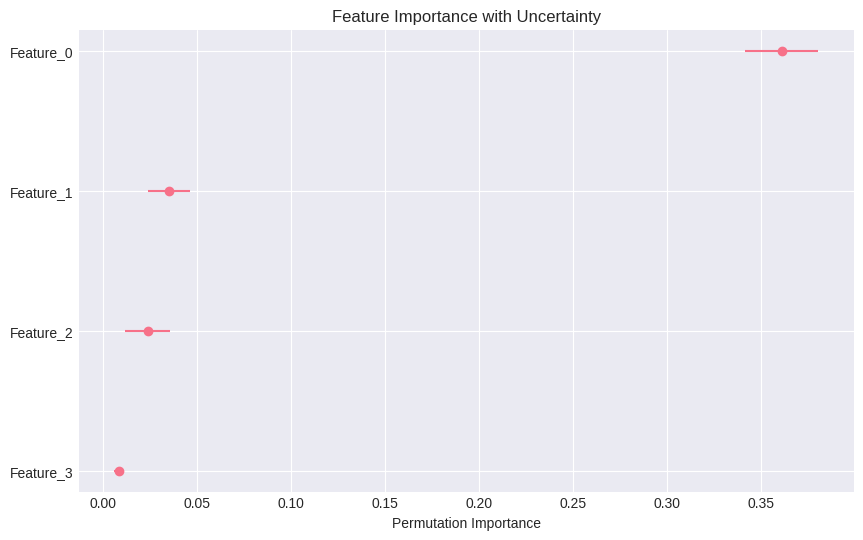

In [ ]:
# Method 2: Permutation Importance (Model-agnostic)
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    random_forest, X_test, y_test, n_repeats=10, random_state=42
)

perm_imp_df = pd.DataFrame({
    'feature': [f'Feature_{i}' for i in range(4)],
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.errorbar(perm_imp_df['importance'], range(len(perm_imp_df)),
             xerr=perm_imp_df['std'], fmt='o')
plt.yticks(range(len(perm_imp_df)), perm_imp_df['feature'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance with Uncertainty')
plt.gca().invert_yaxis()
plt.show()

### Partial Dependence Plots (PDPs)

**What it is:**  
Plots showing marginal effect of a feature on predictions.

**Why we use it:**  
Visualizes non-linear feature–output relationships.

**Limitations:**  
- Assumes feature independence.
- Misleading when features are correlated.

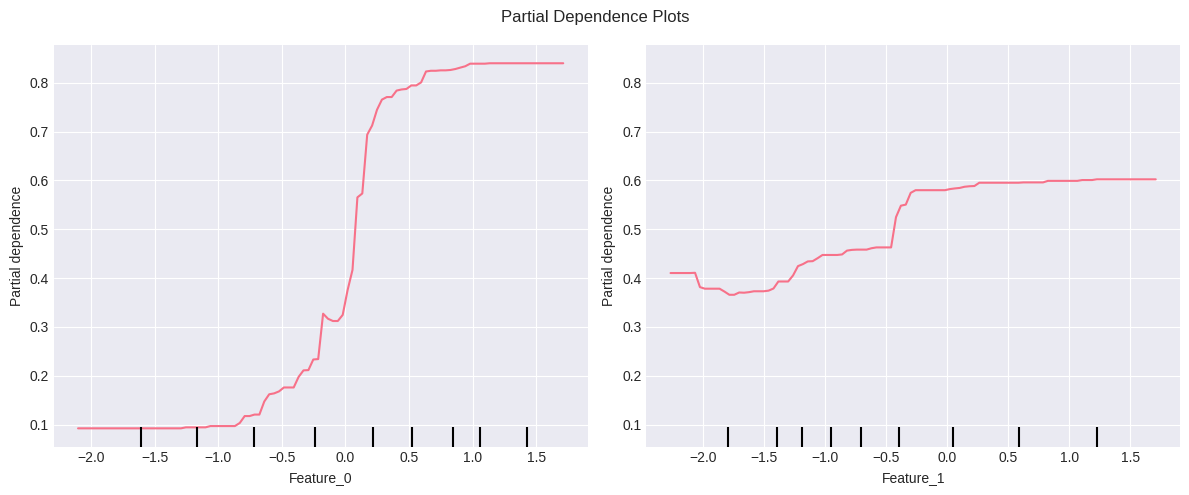

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Create PDP for top features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Select top 2 features
top_indices = feature_importance['feature'][:2].tolist()

display = PartialDependenceDisplay.from_estimator(
    random_forest, X_train, top_indices,
    feature_names=[f'Feature_{i}' for i in range(4)],
    ax=axes
)
fig.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.show()

### SHAP (SHapley Additive exPlanations)

**What it is:**  
Game-theoretic attribution of feature contributions.

**Why we use it:**  
Provides consistent local and global explanations.

**Limitations:**  
- Computationally expensive.
- Attribution ≠ causation.


ExactExplainer explainer: 301it [00:13, 11.76it/s]                         


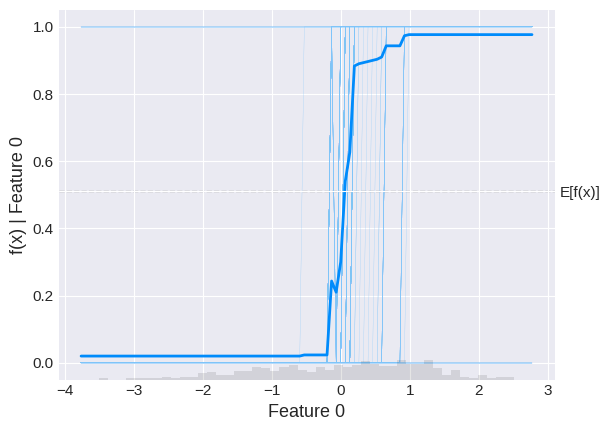

In [ ]:
import shap

model = random_forest
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

shap.partial_dependence_plot(
    0,
    model.predict,
    X_test,
    model_expected_value=True,
)

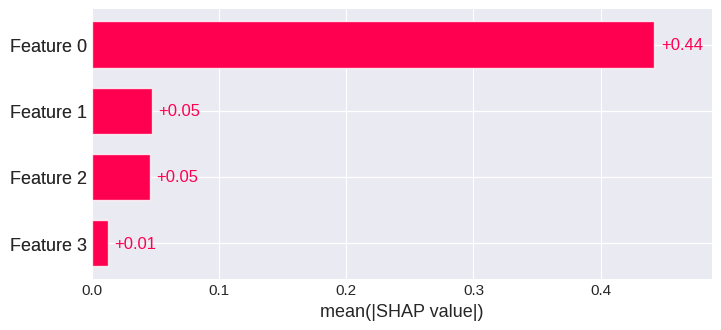

In [ ]:
shap.plots.bar(shap_values)

#### Global vs Local

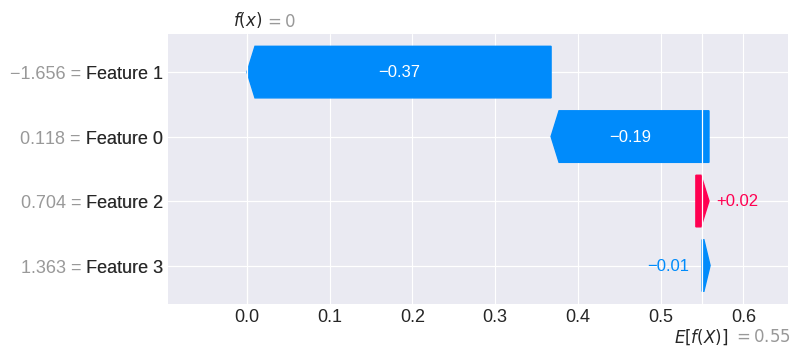

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=14)

In [ ]:
linear_model.coef_ * X_test[0], + linear_model.intercept_

(array([ 0.03331455, -0.18766532,  0.01531331,  0.02771898]),
 np.float64(0.5336671533200087))

### LIME

**What it is:**  
Approximates complex models locally with simple linear models.

**Why we use it:**  
Explains black-box models at the sample level.

**Limitations:**  
- Unstable across runs.
- Only locally faithful.

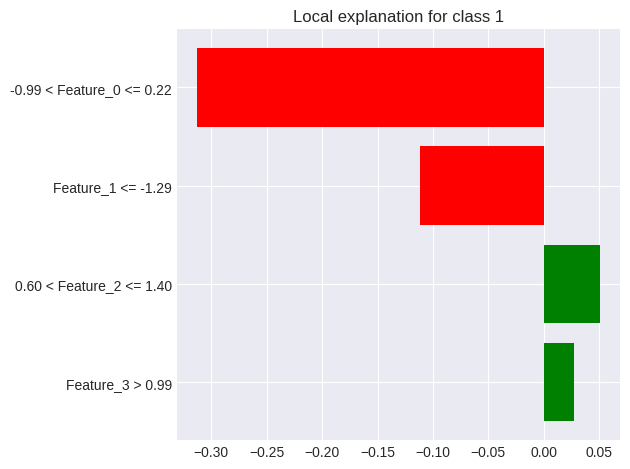

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train,
    feature_names=[f'Feature_{i}' for i in range(4)],
    mode='classification'
)

explanation = lime_explainer.explain_instance(
    X_test[0],
    random_forest.predict_proba,
    num_features=4
)

# Visualize explanation
fig = explanation.as_pyplot_figure()
plt.tight_layout()
plt.show()

# # Get explanation as list
# print("\nFeature contributions:")
# for feature, weight in explanation.as_list():
#     print(f"{feature}: {weight:.4f}")

### Counterfactuals


#### Goal:

Given an input $x$ classified by a model $f(x)$, we want to find a small change to $x$ (called a *counterfactual* $x'$) such that the model changes its prediction (e.g., from "Reject" to "Approve").


#### Basic Idea:

Find the closest $x'$ to $x$ such that:

* $f(x') \neq f(x)$
* $x'$ is as similar to $x$ as possible


#### Simple Algorithm (Gradient-Free Version)

##### Assumptions:

* Model $f$ is a black box (you can only query it)
* Input $x$ is numerical
* You can measure distance using something like Euclidean distance

In [ ]:
def find_counterfactual(f, x_orig, target_label, step_size=0.1, max_iter=1000):
    x_cf = x_orig.copy()

    for _ in range(max_iter):
        for i in range(len(x_cf)):
            # Try increasing feature i
            x_try = x_cf.copy()
            x_try[i] += step_size
            if f([x_try])[0] == target_label:
                return x_try

            # Try decreasing feature i
            x_try[i] -= 2 * step_size
            if f([x_try])[0] == target_label:
                return x_try

    return None  # No counterfactual found

In [ ]:
original = X_test[0]
cf = find_counterfactual(random_forest.predict, X_test[0], 1)

print(f'Original {original}, prediction {random_forest.predict([original])}')
print(f'Counterfactual {cf}, prediction {random_forest.predict([cf])}')

Original [ 0.11752616 -1.65552346  0.70415519  1.36340863], prediction [0]
Counterfactual [ 0.21752616 -1.65552346  0.70415519  1.36340863], prediction [1]


## Bonus Content - Chain of Thought Prompting

### Understanding CoT

**What it is:**  
Step-by-step reasoning generated by LLMs.

**Why we use it:**  
Improves transparency of model reasoning.

**Limitations:**  
- CoT may not reflect true internal reasoning.
- Risk of hallucinated reasoning.

In [ ]:
!pip install instructor

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal
from openai import OpenAI
import instructor
import getpass

api_key = getpass.getpass("Enter your OPENAI API KEY: ")

# Apply the patch to the OpenAI client
# enables response_model keyword
client = instructor.from_openai(OpenAI(api_key=api_key))


class ClassificationResponse(BaseModel):
    """
    A few-shot example of text classification:

    Examples:
    - "Buy cheap watches now!": SPAM
    - "Meeting at 3 PM in the conference room": NOT_SPAM
    - "You've won a free iPhone! Click here": SPAM
    - "Can you pick up some milk on your way home?": NOT_SPAM
    - "Increase your followers by 10000 overnight!": SPAM
    """

    chain_of_thought: str = Field(
        ...,
        description="The chain of thought that led to the prediction.",
    )
    label: Literal["SPAM", "NOT_SPAM"] = Field(
        ...,
        description="The predicted class label.",
    )

Enter your OPENAI API KEY: ··········


In [ ]:
def classify(data: str) -> ClassificationResponse:
    """Perform single-label classification on the input text."""
    return client.chat.completions.create(
        model="gpt-4o-mini",
        response_model=ClassificationResponse,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: <text>{data}</text>",
            },
        ],
    )

In [ ]:
for text, label in [
    ("Hey Jason! You're awesome", "NOT_SPAM"),
    ("I am a Nigerian orphan and I need your help.", "SPAM"), # -> Popular location + Royalty
]:
    prediction = classify(text)
    print(f"Text: {text},\n\nPredicted Label: {prediction.model_dump()}")
    print('-'*100)

Text: Hey Jason! You're awesome,

Predicted Label: {'chain_of_thought': 'The message is a friendly and positive compliment directed towards someone named Jason, expressing admiration rather than trying to sell something or promote an agenda. Therefore, this message is not spam.', 'label': 'NOT_SPAM'}
----------------------------------------------------------------------------------------------------
Text: I am a Nigerian orphan and I need your help.,

Predicted Label: {'chain_of_thought': 'The text expresses a personal situation, specifically the speaker identifies as an orphan from Nigeria and seeks help. It does not contain any promotional or deceitful content typical of SPAM messages. Instead, it portrays a genuine plea for assistance, which aligns with legitimate communication. Therefore, it should be classified as NOT_SPAM.', 'label': 'NOT_SPAM'}
----------------------------------------------------------------------------------------------------
